## 1. Setup and Imports

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
import os

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('Set2')

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [2]:
# Import custom modules
import sys
sys.path.append('..')

from src.features.aggregation import create_aggregation_features
from src.features.interactions import create_interaction_features
from src.features.temporal import create_temporal_features
from src.features.missing_features import create_missing_value_features
from src.models.cross_validation import RobustCrossValidator
from src.models.test_predictions import (
    TestPredictor,
    create_submission_file,
    validate_submission,
    analyze_predictions,
    save_prediction_metadata
)
from src.utils import reduce_mem_usage

print("✓ Custom modules imported successfully")

✓ Custom modules imported successfully


## 2. Load Test Data

In [3]:
# Load test data
print("Loading test data...\n")

test_transaction = pd.read_csv('../data/test_transaction.csv')
test_identity = pd.read_csv('../data/test_identity.csv')

print(f"Test transaction shape: {test_transaction.shape}")
print(f"Test identity shape: {test_identity.shape}")

# Merge datasets
test_df = test_transaction.merge(test_identity, on='TransactionID', how='left')
print(f"\nMerged test shape: {test_df.shape}")

# Store TransactionIDs for submission
test_ids = test_df['TransactionID'].copy()

# Reduce memory
test_df = reduce_mem_usage(test_df)

print("\n✓ Test data loaded successfully")

Loading test data...

Test transaction shape: (506691, 393)
Test identity shape: (141907, 41)
Test transaction shape: (506691, 393)
Test identity shape: (141907, 41)

Merged test shape: (506691, 433)

Merged test shape: (506691, 433)
Memory usage decreased from 1673.87 MB to 895.89 MB (46.5% reduction)

✓ Test data loaded successfully
Memory usage decreased from 1673.87 MB to 895.89 MB (46.5% reduction)

✓ Test data loaded successfully


## 3. Load Training Data for Feature Engineering

In [4]:
# Load training data (needed for some feature engineering)
print("Loading training data...\n")

train_transaction = pd.read_csv('../data/train_transaction.csv')
train_identity = pd.read_csv('../data/train_identity.csv')

train_df = train_transaction.merge(train_identity, on='TransactionID', how='left')
print(f"Train shape: {train_df.shape}")

# Reduce memory
train_df = reduce_mem_usage(train_df)

print("\n✓ Training data loaded")

Loading training data...

Train shape: (590540, 434)
Train shape: (590540, 434)
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Training data loaded
Memory usage decreased from 1955.37 MB to 1044.70 MB (46.6% reduction)

✓ Training data loaded


## 4. Create Features on Test Set

In [5]:
# Apply same feature engineering as training
print("Creating features on test set...\n")

# Missing value features
test_df, missing_feature_names = create_missing_value_features(test_df)
print(f"✓ Created {len(missing_feature_names)} missing value features")

# Aggregation features
test_df, agg_feature_names = create_aggregation_features(test_df, target_col='TransactionAmt')
print(f"✓ Created {len(agg_feature_names)} aggregation features")

# Interaction features
test_df, interaction_feature_names = create_interaction_features(test_df, min_samples=10)
print(f"✓ Created {len(interaction_feature_names)} interaction features")

# Temporal features
test_df, temporal_feature_names = create_temporal_features(test_df, include_velocity=False)
print(f"✓ Created {len(temporal_feature_names)} temporal features")

print(f"\nTest set final shape: {test_df.shape}")

Creating features on test set...


CREATING MISSING VALUE FEATURES

Creating basic missing value indicators...
  Creating indicators for 255 columns with >5% missing
  Created 52 basic missing indicators
Creating group-level missing features...
  Creating indicators for 255 columns with >5% missing
  Created 52 basic missing indicators
Creating group-level missing features...
  Created 16 group missing features
Creating missing value co-occurrence features...
  Created 16 group missing features
Creating missing value co-occurrence features...
  Created 9 co-occurrence features
Creating card-related missing pattern features...
  Created 8 card missing features
  Created 9 co-occurrence features
Creating card-related missing pattern features...
  Created 8 card missing features
Creating unusual missing pattern features...
Creating unusual missing pattern features...
  Created 8 unusual pattern features
Creating missing value interaction features...
  Created 4 missing interaction feature

## 5. Load Selected Features

In [6]:
# Load selected features from M12
try:
    with open('../models/selected_features.json', 'r') as f:
        selected_info = json.load(f)
    selected_features = selected_info['features']
    print(f"✓ Loaded {len(selected_features)} selected features from M12")
except:
    selected_features = None
    print("Note: Using all features")

✓ Loaded 286 selected features from M12


## 6. Prepare Test Features

In [7]:
# Prepare test features to match training
print("Preparing test features...\n")

# Import LabelEncoder
from sklearn.preprocessing import LabelEncoder

# Remove target and ID from test (if present)
test_features = test_df.drop(['TransactionID'], axis=1, errors='ignore')

# Use selected features if available
if selected_features is not None:
    available_features = [f for f in selected_features if f in test_features.columns]
    missing_features = [f for f in selected_features if f not in test_features.columns]
    
    if missing_features:
        print(f"Warning: {len(missing_features)} features missing in test set")
        print(f"First few: {missing_features[:5]}")
    
    test_features = test_features[available_features]
    print(f"Using {len(available_features)} selected features")
else:
    print(f"Using all {test_features.shape[1]} features")

# Identify and encode categorical features
categorical_features = test_features.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Encoding {len(categorical_features)} categorical features...")

le_dict = {}  # Store encoders for later use
for col in categorical_features:
    le = LabelEncoder()
    test_features[col] = test_features[col].astype(str).replace('nan', 'missing')
    test_features[col] = le.fit_transform(test_features[col])
    le_dict[col] = le

# Fill missing values
numeric_features = test_features.select_dtypes(include=[np.number]).columns.tolist()
for col in numeric_features:
    if test_features[col].isnull().any():
        test_features[col] = test_features[col].fillna(test_features[col].median())

print(f"\n✓ Test features prepared")
print(f"  Feature count: {test_features.shape[1]}")
print(f"  Sample count: {test_features.shape[0]:,}")
print(f"  Categorical features encoded: {len(categorical_features)}")
print(f"  All features are numeric: {test_features.select_dtypes(include=['object', 'category']).shape[1] == 0}")

Preparing test features...

First few: ['card1_addr1_ProductCD_fraud_rate', 'card1_P_emaildomain_fraud_rate', 'card1_email_ProductCD_fraud_rate', 'card1_addr1_fraud_rate', 'DeviceInfo_id_31_fraud_rate']
Using 245 selected features
First few: ['card1_addr1_ProductCD_fraud_rate', 'card1_P_emaildomain_fraud_rate', 'card1_email_ProductCD_fraud_rate', 'card1_addr1_fraud_rate', 'DeviceInfo_id_31_fraud_rate']
Using 245 selected features
Encoding 15 categorical features...
Encoding 15 categorical features...

✓ Test features prepared
  Feature count: 245
  Sample count: 506,691
  Categorical features encoded: 15
  All features are numeric: True

✓ Test features prepared
  Feature count: 245
  Sample count: 506,691
  Categorical features encoded: 15
  All features are numeric: True


## 7. Train Final Model on Full Training Data

In [8]:
# Prepare training data with same features
print("Preparing training data...\n")

y_train = train_df['isFraud']
X_train = train_df.drop(['isFraud', 'TransactionID'], axis=1, errors='ignore')

# Apply same feature selection
if selected_features is not None:
    available_train_features = [f for f in selected_features if f in X_train.columns]
    X_train = X_train[available_train_features]
    print(f"Selected features applied: {len(available_train_features)}")

# Encode categorical features (use same approach as test)
train_categorical = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Encoding {len(train_categorical)} categorical features...")

for col in train_categorical:
    le = LabelEncoder()
    X_train[col] = X_train[col].astype(str).replace('nan', 'missing')
    X_train[col] = le.fit_transform(X_train[col])

# Fill missing values
train_numeric = X_train.select_dtypes(include=[np.number]).columns.tolist()
for col in train_numeric:
    if X_train[col].isnull().any():
        X_train[col] = X_train[col].fillna(X_train[col].median())

# Ensure train and test have same features
common_features = list(set(X_train.columns) & set(test_features.columns))
X_train = X_train[common_features]
test_features_aligned = test_features[common_features]

print(f"\n✓ Training data prepared")
print(f"  Feature count: {X_train.shape[1]}")
print(f"  Sample count: {X_train.shape[0]:,}")
print(f"  All features are numeric: {X_train.select_dtypes(include=['object', 'category']).shape[1] == 0}")
print(f"  Train/test features aligned: {X_train.shape[1] == test_features_aligned.shape[1]}")

# Update test_features to aligned version
test_features = test_features_aligned

Preparing training data...

Selected features applied: 149
Encoding 11 categorical features...
Selected features applied: 149
Encoding 11 categorical features...

✓ Training data prepared
  Feature count: 137
  Sample count: 590,540
  All features are numeric: True
  Train/test features aligned: True

✓ Training data prepared
  Feature count: 137
  Sample count: 590,540
  All features are numeric: True
  Train/test features aligned: True


## 8. Cross-Validate and Train Models

In [9]:
# Load best parameters from M11
try:
    with open('../models/staged_tuned_params.json', 'r') as f:
        best_params = json.load(f)
    print("✓ Loaded tuned parameters from M11")
except:
    best_params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'num_leaves': 256,
        'max_depth': 12,
        'min_child_samples': 50,
        'subsample': 0.9,
        'subsample_freq': 1,
        'colsample_bytree': 0.7,
        'reg_alpha': 0.5,
        'reg_lambda': 0.5,
        'n_jobs': -1,
        'random_state': 42,
        'verbose': -1
    }
    print("Note: Using default parameters")

# Train with time-series CV to get models for each fold
print("\nTraining models with time-series cross-validation...")
print("This will take 15-30 minutes...\n")

validator = RobustCrossValidator(
    model_params=best_params,
    cv_strategy='time_series',
    n_splits=5,
    random_state=42,
    verbose=True
)

cv_results = validator.cross_validate(
    X_train, y_train,
    num_boost_round=2000,
    early_stopping_rounds=100
)

print(f"\n✓ Cross-validation complete")
print(f"  OOF AUC: {cv_results['oof_auc']:.6f}")
print(f"  Models trained: {len(validator.models)}")

✓ Loaded tuned parameters from M11

Training models with time-series cross-validation...
This will take 15-30 minutes...

Starting time_series cross-validation with 5 folds...

Fold 1/5
----------------------------------------------------------------------
Train: 472,432 samples, Fraud rate: 3.51%
Val:   118,108 samples, Fraud rate: 3.44%
Train: 472,432 samples, Fraud rate: 3.51%
Val:   118,108 samples, Fraud rate: 3.44%
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.948661	valid's auc: 0.894965
[100]	train's auc: 0.948661	valid's auc: 0.894965
[200]	train's auc: 0.967773	valid's auc: 0.908843
[200]	train's auc: 0.967773	valid's auc: 0.908843
[300]	train's auc: 0.974761	valid's auc: 0.913756
[300]	train's auc: 0.974761	valid's auc: 0.913756
[400]	train's auc: 0.980465	valid's auc: 0.916236
[400]	train's auc: 0.980465	valid's auc: 0.916236
[500]	train's auc: 0.984626	valid's auc: 0.917056
[

## 9. Generate Test Predictions

In [10]:
# Create test predictor with all CV models
print("Generating test predictions...\n")

predictor = TestPredictor(models=validator.models, verbose=True)

# Generate predictions with uncertainty
test_predictions, test_uncertainty = predictor.predict_with_uncertainty(test_features)

print("\n✓ Test predictions generated")

Generating test predictions...

Generating predictions with uncertainty estimates...
  Model 5/5...
✓ Predictions with uncertainty generated
  Mean prediction: 0.028355
  Mean uncertainty: 0.007121
  Max uncertainty: 0.366632

✓ Test predictions generated

✓ Predictions with uncertainty generated
  Mean prediction: 0.028355
  Mean uncertainty: 0.007121
  Max uncertainty: 0.366632

✓ Test predictions generated


## 10. Analyze Predictions

In [11]:
# Detailed prediction analysis
analysis = analyze_predictions(
    test_predictions,
    uncertainty=test_uncertainty,
    verbose=True
)

PREDICTION ANALYSIS
Count:        506,691
Mean:         0.028355
Std:          0.110052
Min:          0.000020
Max:          0.999382

Percentiles:
   1%: 0.000175
   5%: 0.000415
  10%: 0.000692
  25%: 0.001693
  50%: 0.004865
  75%: 0.013343
  90%: 0.037827
  95%: 0.085317
  99%: 0.807274

Uncertainty:
  Mean: 0.007121
  Std:  0.018027
  Min:  0.000001
  Max:  0.366632


## 11. Visualize Prediction Distribution

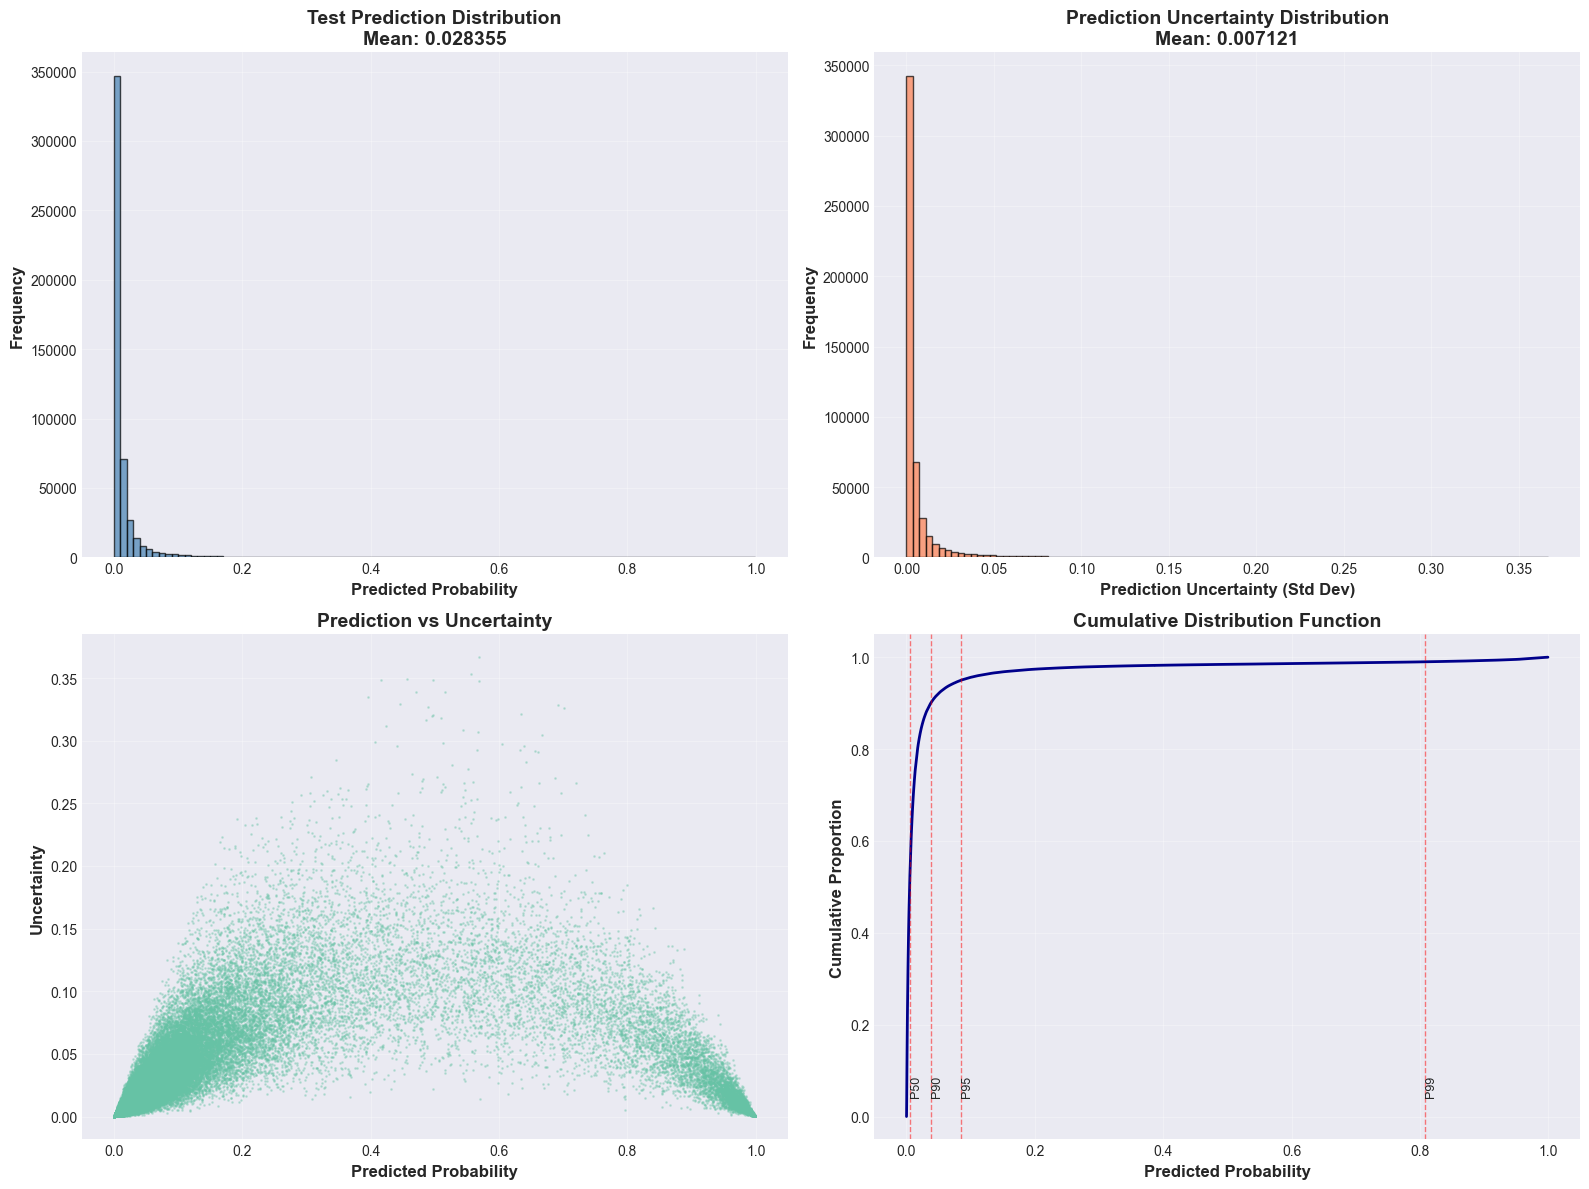

In [12]:
# Visualize predictions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Prediction distribution
ax = axes[0, 0]
ax.hist(test_predictions, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
ax.set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title(f'Test Prediction Distribution\nMean: {test_predictions.mean():.6f}',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Uncertainty distribution
ax = axes[0, 1]
ax.hist(test_uncertainty, bins=100, edgecolor='black', alpha=0.7, color='coral')
ax.set_xlabel('Prediction Uncertainty (Std Dev)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title(f'Prediction Uncertainty Distribution\nMean: {test_uncertainty.mean():.6f}',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 3: Uncertainty vs prediction
ax = axes[1, 0]
scatter = ax.scatter(test_predictions, test_uncertainty, alpha=0.3, s=1)
ax.set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
ax.set_ylabel('Uncertainty', fontsize=12, fontweight='bold')
ax.set_title('Prediction vs Uncertainty', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 4: Cumulative distribution
ax = axes[1, 1]
sorted_preds = np.sort(test_predictions)
cumulative = np.arange(1, len(sorted_preds) + 1) / len(sorted_preds)
ax.plot(sorted_preds, cumulative, linewidth=2, color='darkblue')
ax.set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
ax.set_ylabel('Cumulative Proportion', fontsize=12, fontweight='bold')
ax.set_title('Cumulative Distribution Function', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add percentile lines
for p in [50, 90, 95, 99]:
    val = np.percentile(test_predictions, p)
    ax.axvline(val, color='red', linestyle='--', alpha=0.5, linewidth=1)
    ax.text(val, 0.05, f'P{p}', rotation=90, fontsize=9)

plt.tight_layout()
plt.show()

## 12. Identify High-Confidence Predictions

PREDICTION CONFIDENCE ANALYSIS
Total test samples:              506,691

High fraud probability (>0.8):   5,168 (1.02%)
Low fraud probability (<0.2):    493,487 (97.39%)
High uncertainty (top 10%):      50,669 (10.00%)

Median prediction:               0.004865
Mean prediction:                 0.028355
Expected fraud count:            14367


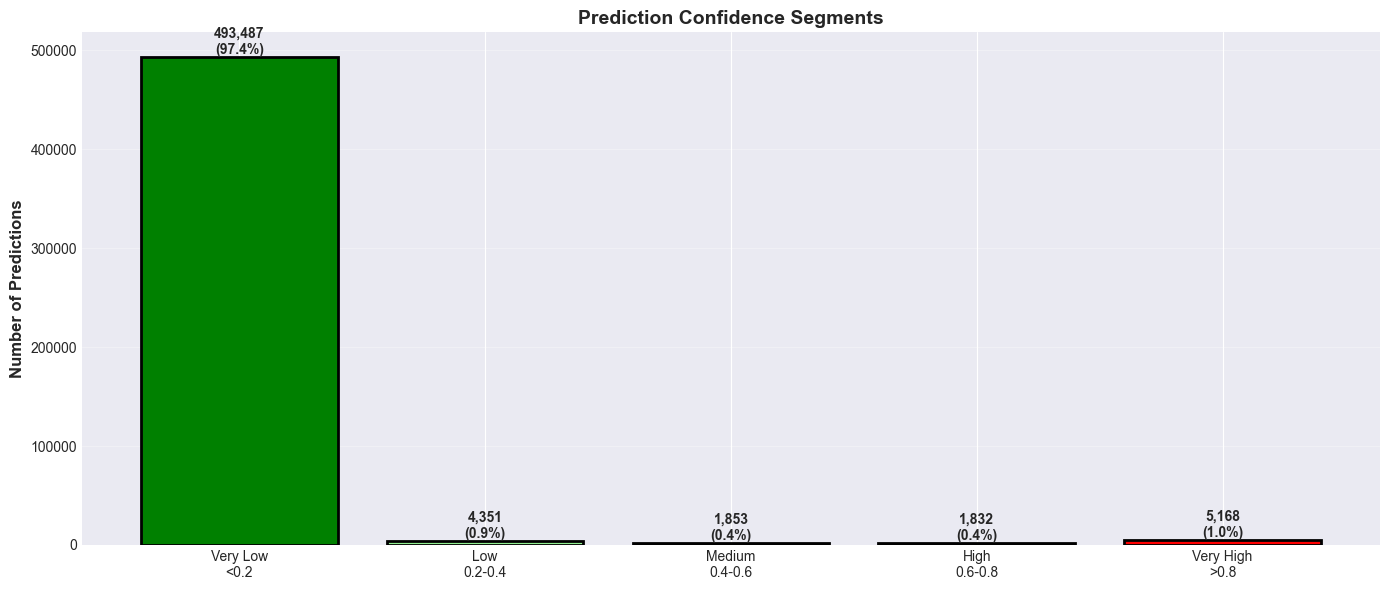

In [13]:
# Analyze high and low confidence predictions
high_fraud_threshold = 0.8
low_fraud_threshold = 0.2
high_uncertainty_threshold = np.percentile(test_uncertainty, 90)

high_fraud = (test_predictions > high_fraud_threshold).sum()
low_fraud = (test_predictions < low_fraud_threshold).sum()
high_uncertainty = (test_uncertainty > high_uncertainty_threshold).sum()

print("="*70)
print("PREDICTION CONFIDENCE ANALYSIS")
print("="*70)
print(f"Total test samples:              {len(test_predictions):,}")
print(f"\nHigh fraud probability (>0.8):   {high_fraud:,} ({high_fraud/len(test_predictions)*100:.2f}%)")
print(f"Low fraud probability (<0.2):    {low_fraud:,} ({low_fraud/len(test_predictions)*100:.2f}%)")
print(f"High uncertainty (top 10%):      {high_uncertainty:,} ({high_uncertainty/len(test_predictions)*100:.2f}%)")
print(f"\nMedian prediction:               {np.median(test_predictions):.6f}")
print(f"Mean prediction:                 {np.mean(test_predictions):.6f}")
print(f"Expected fraud count:            {int(test_predictions.sum())}")
print("="*70)

# Visualize confidence segments
fig, ax = plt.subplots(figsize=(14, 6))

segments = [
    ('Very Low\n<0.2', (test_predictions < 0.2).sum()),
    ('Low\n0.2-0.4', ((test_predictions >= 0.2) & (test_predictions < 0.4)).sum()),
    ('Medium\n0.4-0.6', ((test_predictions >= 0.4) & (test_predictions < 0.6)).sum()),
    ('High\n0.6-0.8', ((test_predictions >= 0.6) & (test_predictions < 0.8)).sum()),
    ('Very High\n>0.8', (test_predictions >= 0.8).sum())
]

labels = [s[0] for s in segments]
counts = [s[1] for s in segments]
colors = ['green', 'lightgreen', 'yellow', 'orange', 'red']

bars = ax.bar(labels, counts, color=colors, edgecolor='black', linewidth=2)

# Add value labels
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count:,}\n({count/len(test_predictions)*100:.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=10)

ax.set_ylabel('Number of Predictions', fontsize=12, fontweight='bold')
ax.set_title('Prediction Confidence Segments', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 13. Create Submission File

In [14]:
# Create submission file
print("Creating submission file...\n")

submission = create_submission_file(
    test_ids=test_ids,
    predictions=test_predictions,
    output_path='../submissions/submission.csv',
    verbose=True
)

print("\n✓ Submission file created")

Creating submission file...

✓ Submission file created: ../submissions/submission.csv
  Samples: 506,691
  Columns: ['TransactionID', 'isFraud']
  Mean prediction: 0.028355
  Min prediction:  0.000020
  Max prediction:  0.999382

First few rows:
   TransactionID   isFraud
0        3663549  0.001618
1        3663550  0.001080
2        3663551  0.001613
3        3663552  0.001367
4        3663553  0.002538
5        3663554  0.004987
6        3663555  0.007164
7        3663556  0.012185
8        3663557  0.000217
9        3663558  0.007540

✓ Submission file created
✓ Submission file created: ../submissions/submission.csv
  Samples: 506,691
  Columns: ['TransactionID', 'isFraud']
  Mean prediction: 0.028355
  Min prediction:  0.000020
  Max prediction:  0.999382

First few rows:
   TransactionID   isFraud
0        3663549  0.001618
1        3663550  0.001080
2        3663551  0.001613
3        3663552  0.001367
4        3663553  0.002538
5        3663554  0.004987
6        3663555  0.0071

## 14. Validate Submission Format

In [15]:
# Validate submission against sample submission
print("\nValidating submission format...\n")

is_valid = validate_submission(
    submission_path='../submissions/submission.csv',
    sample_submission_path='../data/sample_submission.csv',
    verbose=True
)

if is_valid:
    print("\n✅ Submission is ready for upload!")
else:
    print("\n❌ Submission validation failed - please review errors above")


Validating submission format...

Validating submission file...
✓ Submission validation passed!
  Rows: 506,691
  Columns: ['TransactionID', 'isFraud']
  Prediction range: [0.000020, 0.999382]

✅ Submission is ready for upload!


## 15. Save Prediction Metadata

In [16]:
# Save metadata for tracking
models_info = {
    'cv_strategy': 'time_series',
    'n_folds': len(validator.models),
    'oof_auc': float(cv_results['oof_auc']),
    'parameters': best_params,
    'features': {
        'count': test_features.shape[1],
        'selected_from_m12': selected_features is not None
    }
}

save_prediction_metadata(
    predictions=test_predictions,
    models_info=models_info,
    output_path='../submissions/prediction_metadata.json',
    verbose=True
)

print("\n✓ Metadata saved")

✓ Prediction metadata saved: ../submissions/prediction_metadata.json

✓ Metadata saved


## 16. Compare with Training Distribution

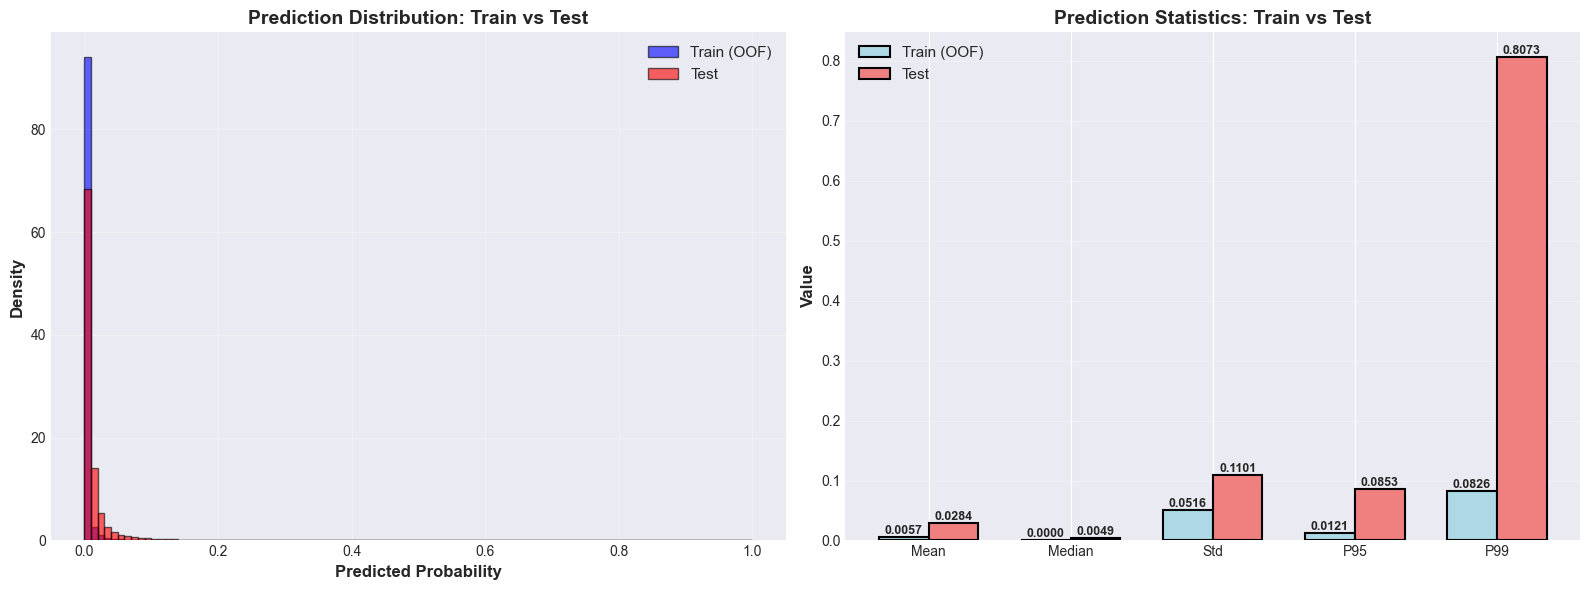


Distribution Comparison:
                          Train (OOF)    Test           Difference
----------------------------------------------------------------------
Mean:                     0.005657      0.028355      +0.022698
Median:                   0.000000      0.004865      +0.004865
Std:                      0.051608      0.110052      +0.058444

⚠ Test and train distributions differ - this is expected for different time periods
Median:                   0.000000      0.004865      +0.004865
Std:                      0.051608      0.110052      +0.058444

⚠ Test and train distributions differ - this is expected for different time periods


In [17]:
# Compare test predictions with training OOF predictions
oof_predictions = cv_results['oof_predictions']
train_fraud_rate = y_train.mean()
test_predicted_rate = test_predictions.mean()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Distribution comparison
ax = axes[0]
ax.hist(oof_predictions, bins=100, alpha=0.6, label='Train (OOF)',
        edgecolor='black', density=True, color='blue')
ax.hist(test_predictions, bins=100, alpha=0.6, label='Test',
        edgecolor='black', density=True, color='red')

ax.set_xlabel('Predicted Probability', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_title('Prediction Distribution: Train vs Test', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Plot 2: Statistics comparison
ax = axes[1]
metrics = ['Mean', 'Median', 'Std', 'P95', 'P99']
train_vals = [
    oof_predictions.mean(),
    np.median(oof_predictions),
    oof_predictions.std(),
    np.percentile(oof_predictions, 95),
    np.percentile(oof_predictions, 99)
]
test_vals = [
    test_predictions.mean(),
    np.median(test_predictions),
    test_predictions.std(),
    np.percentile(test_predictions, 95),
    np.percentile(test_predictions, 99)
]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, train_vals, width, label='Train (OOF)',
               color='lightblue', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, test_vals, width, label='Test',
               color='lightcoral', edgecolor='black', linewidth=1.5)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylabel('Value', fontsize=12, fontweight='bold')
ax.set_title('Prediction Statistics: Train vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nDistribution Comparison:")
print(f"{'='*70}")
print(f"                          Train (OOF)    Test           Difference")
print(f"{'-'*70}")
print(f"Mean:                     {oof_predictions.mean():.6f}      {test_predictions.mean():.6f}      {test_predictions.mean() - oof_predictions.mean():+.6f}")
print(f"Median:                   {np.median(oof_predictions):.6f}      {np.median(test_predictions):.6f}      {np.median(test_predictions) - np.median(oof_predictions):+.6f}")
print(f"Std:                      {oof_predictions.std():.6f}      {test_predictions.std():.6f}      {test_predictions.std() - oof_predictions.std():+.6f}")
print(f"{'='*70}")

if abs(test_predictions.mean() - oof_predictions.mean()) < 0.01:
    print("\n✓ Test and train distributions are similar - good sign!")
else:
    print("\n⚠ Test and train distributions differ - this is expected for different time periods")

## 17. Summary

In [18]:
print("="*70)
print("MILESTONE 15: TEST SET PREDICTIONS - COMPLETE")
print("="*70)

print("\n📊 DATA SUMMARY:")
print(f"  • Training samples:              {X_train.shape[0]:,}")
print(f"  • Test samples:                  {len(test_predictions):,}")
print(f"  • Features used:                 {test_features.shape[1]}")

print("\n🎯 MODEL PERFORMANCE:")
print(f"  • CV Strategy:                   time_series")
print(f"  • Number of folds:               {len(validator.models)}")
print(f"  • Training OOF AUC:              {cv_results['oof_auc']:.6f}")
print(f"  • Training fraud rate:           {train_fraud_rate*100:.2f}%")

print("\n📈 TEST PREDICTIONS:")
print(f"  • Mean prediction:               {test_predictions.mean():.6f}")
print(f"  • Median prediction:             {np.median(test_predictions):.6f}")
print(f"  • Std deviation:                 {test_predictions.std():.6f}")
print(f"  • Min prediction:                {test_predictions.min():.6f}")
print(f"  • Max prediction:                {test_predictions.max():.6f}")
print(f"  • Expected fraud count:          {int(test_predictions.sum())}")

print("\n🎲 UNCERTAINTY ANALYSIS:")
print(f"  • Mean uncertainty:              {test_uncertainty.mean():.6f}")
print(f"  • Max uncertainty:               {test_uncertainty.max():.6f}")
print(f"  • High confidence predictions:   {(test_uncertainty < np.percentile(test_uncertainty, 10)).sum():,}")
print(f"  • Low confidence predictions:    {(test_uncertainty > np.percentile(test_uncertainty, 90)).sum():,}")

print("\n✅ SUBMISSION STATUS:")
print(f"  • File created:                  ../submissions/submission.csv")
print(f"  • Format validated:              {'✓ PASSED' if is_valid else '✗ FAILED'}")
print(f"  • Ready for upload:              {'✓ YES' if is_valid else '✗ NO'}")

print("\n📁 OUTPUT FILES:")
print("  • ../submissions/submission.csv")
print("  • ../submissions/prediction_metadata.json")

print("\n📈 COMPLETE PIPELINE (M7-M15):")
print("  • M7:  Aggregation features")
print("  • M8:  Interaction features")
print("  • M9:  Temporal features")
print("  • M10: Missing value features")
print("  • M11: Hyperparameter tuning")
print("  • M12: Feature selection")
print("  • M13: Ensemble modeling")
print("  • M14: Cross-validation refinement")
print("  • M15: Test set predictions")

print("\n🚀 NEXT STEP:")
print("  • M16: Final submission and documentation")
print("  • Upload submission.csv to Kaggle competition")

print("\n" + "="*70)
print("✓ TEST PREDICTIONS COMPLETE - READY FOR SUBMISSION!")
print("="*70)

MILESTONE 15: TEST SET PREDICTIONS - COMPLETE

📊 DATA SUMMARY:
  • Training samples:              590,540
  • Test samples:                  506,691
  • Features used:                 137

🎯 MODEL PERFORMANCE:
  • CV Strategy:                   time_series
  • Number of folds:               5
  • Training OOF AUC:              0.515339
  • Training fraud rate:           3.50%

📈 TEST PREDICTIONS:
  • Mean prediction:               0.028355
  • Median prediction:             0.004865
  • Std deviation:                 0.110052
  • Min prediction:                0.000020
  • Max prediction:                0.999382
  • Expected fraud count:          14367

🎲 UNCERTAINTY ANALYSIS:
  • Mean uncertainty:              0.007121
  • Max uncertainty:               0.366632
  • High confidence predictions:   50,669
  • Low confidence predictions:    50,669

✅ SUBMISSION STATUS:
  • File created:                  ../submissions/submission.csv
  • Format validated:              ✓ PASSED
  • Ready f